# Initialization

In [2]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind

# Clean the data set

In [3]:
# Import and clean data set

# df = pd.read_csv('datafile_fullynormalized.txt', sep='\t', header = 0, index_col = 2)
df = pd.read_excel('datafile_fullynormalized_collapsed.xlsx', header = 0, index_col = 2)

df.index.name = None
df.columns.name = "Gene"

# Drop columns by name
df.drop(['Protein', 'Molecule', 'UniProt'], axis=1, inplace=True)

df = df.dropna()

# z-score normalize the rows and columns of df_nolabels
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Copy header as a new row
df.loc['Participant'] = [p[0] for p in df.columns]

# Replace C with "Control"
# Replace P with "Patient"
df.loc['Participant'] = df.loc['Participant'].replace('C', 'Control')
df.loc['Participant'] = df.loc['Participant'].replace('P', 'Patient')

# transpose the original df for future use (volcano plot)
df_transposed = df.T
# drop index column
df_transposed.index.name = None
# drop column 0
df_transposed= df_transposed.reset_index(drop=True)

In [4]:
df_transposed


,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX,Participant
0,0.091205,-0.366126,-1.446105,-0.549432,-0.536944,-0.299501,-0.292182,-0.820226,-0.587184,-0.819323,...,-0.754402,-0.207058,0.080058,0.843044,-0.394226,0.16983,1.073171,-0.474608,-1.442735,Control
1,7.078895,-0.189053,0.419728,-0.361978,0.003758,-0.228679,-0.94904,-0.855227,-0.900711,-0.286599,...,-0.231702,0.21365,0.145059,0.251875,-0.187077,0.733269,0.101965,-0.240045,1.236425,Control
2,1.069358,-0.191105,0.994347,0.448254,-0.98269,0.026621,-1.02467,-0.842347,-1.039194,-1.054956,...,-0.718431,-0.022314,0.891907,1.223247,-1.03287,-0.064138,0.978747,-0.256897,-0.46137,Control
3,-0.410483,-0.447277,0.976399,-0.608533,0.05802,-0.271733,-0.146542,-0.475757,-0.593619,-0.152482,...,-0.438253,-0.096045,0.068312,0.56409,0.442088,0.053915,1.12973,0.674238,1.033261,Control
4,0.090994,-0.284493,-0.790543,0.232591,-0.989209,-0.150768,-0.911654,-0.637662,-0.770396,0.531415,...,1.699661,-0.181916,-0.083498,2.361521,-1.254042,-0.254261,1.329205,0.231543,-0.825308,Control
5,-0.391397,-0.293338,-0.042582,-0.514884,-1.274313,-0.337742,-0.596134,-0.600139,0.039612,-0.084929,...,0.227097,-0.317169,0.094485,-0.579469,-0.372421,-0.435583,-0.540338,-0.765723,-0.616618,Control
6,-0.482971,-0.274342,-0.595659,-0.505113,-0.747419,-0.189681,-0.652587,-0.548021,-0.779703,-0.43508,...,-0.354712,-0.282411,-0.258266,0.428934,-0.300965,0.099608,0.981353,-0.48687,-0.646738,Control
7,0.155578,-0.461104,-0.083005,0.029682,-0.468004,-0.213198,-0.468214,-0.374098,-0.073537,-1.128378,...,-1.011909,-0.214178,-0.168294,0.54777,-0.504577,-0.272006,0.572758,-0.678586,0.322707,Control
8,0.292637,-0.713775,-1.679806,-0.819734,-0.820285,-0.420879,1.022425,0.395356,0.956157,-0.724259,...,-0.614061,-0.314105,-0.328098,0.353571,-0.698374,6.092002,0.461969,-0.057444,0.302116,Control
9,0.16033,1.576058,0.217666,-0.058552,0.488821,-0.422026,1.178486,1.909698,1.309975,-0.049642,...,-0.891237,-0.359296,-0.631328,-0.464839,1.945627,-0.531452,-0.545974,0.34744,0.462984,Control


In [5]:
# how to make the first box of the first row "gene"
df_transposed.columns.name = "Gene"


In [6]:
# Prepare for heat map

participant_labels = df.loc['Participant', :]
df_nolabels = df.drop('Participant', axis=0)

color_map = {'Patient': 'orange', 'Control': 'lightgreen'}
col_colors = participant_labels.map(color_map)

In [7]:
# drop below the 2.5th percentile and above the 97.5th percentile (i.e., outliers)
df_nolabels = df_nolabels.apply(lambda x: np.clip(x, x.quantile(0.025), x.quantile(0.975)), axis=1)

df_nolabels = df_nolabels.apply(pd.to_numeric, errors = "coerce")

In [8]:
df_nolabels

,C1,C2,C3,C4,C5,C8,C9,C11,C14,C15,...,P20,P21,P24,P25,P27,P28,P29,P30,P31,P32
A1BG,0.091205,1.219596,1.069358,-0.410483,0.090994,-0.391397,-0.482971,0.155578,0.292637,0.160330,...,0.209466,-0.475721,-0.425574,0.141805,-0.048056,-0.813057,0.396161,-0.400275,-0.527712,-1.000185
A1CF,-0.366126,-0.189053,-0.191105,-0.447277,-0.284493,-0.293338,-0.274342,-0.461104,-0.713775,1.576058,...,0.547655,0.083328,-0.188776,-0.038749,-0.493015,-0.452296,0.027670,-0.084262,-0.583087,-0.074083
A2M,-1.446105,0.419728,0.994347,0.976399,-0.790543,-0.042582,-0.595659,-0.083005,-1.657184,0.217666,...,1.601749,-0.114500,-0.032125,-1.587779,-0.560666,-0.186923,0.818539,-1.103836,-1.049004,-1.656604
A2ML1,-0.549432,-0.361978,0.448254,-0.608533,0.232591,-0.514884,-0.505113,0.029682,-0.819734,-0.058552,...,3.051367,3.032225,-0.298111,0.473307,1.054623,-0.780598,-0.061627,0.003301,-0.408577,-0.007879
A4GALT,-0.536944,0.003758,-0.982690,0.058020,-0.989209,-1.274313,-0.747419,-0.468004,-0.820285,0.488821,...,0.821062,0.504476,1.699120,-1.307813,0.155162,-1.122708,0.296385,-0.093287,-0.314558,-1.307949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPBP2,-0.394226,-0.187077,-1.032870,0.442088,-1.254042,-0.372421,-0.300965,-0.504577,-0.698374,1.945627,...,0.269205,1.213764,-0.849999,0.401644,-1.209067,-1.261286,0.030626,-0.481358,-1.010244,-0.882870
ZPLD1,0.169830,0.733269,-0.064138,0.053915,-0.254261,-0.435583,0.099608,-0.272006,2.215699,-0.531452,...,-0.085942,-0.228616,-0.678016,-0.620323,-0.522032,-0.776342,0.258578,-0.689597,-0.828330,-0.115197
ZWILCH,1.073171,0.101965,0.978747,1.129730,1.329205,-0.540338,0.981353,0.572758,0.461969,-0.545974,...,-1.102348,-1.362123,-0.317333,0.086650,1.693619,-0.131491,0.841043,0.673976,0.094064,0.854212
ZWINT,-0.474608,-0.240045,-0.256897,0.674238,0.231543,-0.765723,-0.486870,-0.678586,-0.057444,0.347440,...,-0.574639,0.253108,0.487093,0.008524,0.054439,-0.580242,0.461335,-0.162976,-0.295114,0.270262


# Heatmap analysis

/Users/rachel.kim.20/miniconda3/envs/practice/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rachel.kim.20/miniconda3/envs/practice/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


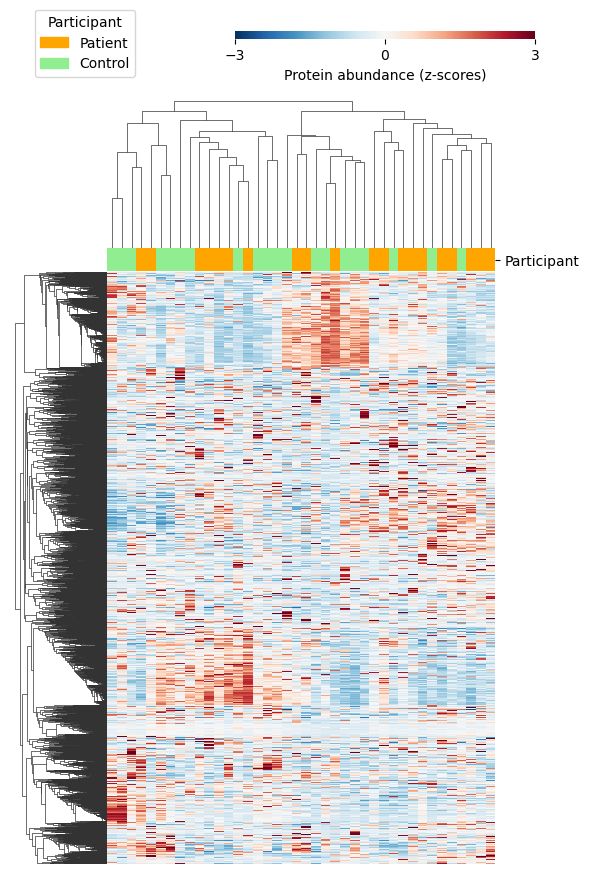

In [9]:
min_color = -3
max_color = 3

hm_average = sns.clustermap(data=df_nolabels,
          method="average",
          metric="correlation",
          xticklabels=[],
          yticklabels=[],
          vmin=min_color,
          vmax=max_color,
          cmap="RdBu_r",
          cbar_pos=(0.4, 1.05, 0.50, 0.01),
          cbar_kws={'orientation': 'horizontal', 'ticks': [min_color, 0, max_color], 'label': 'Protein abundance (z-scores)'},
          col_colors=col_colors,
          figsize=(6, 8))

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(-0.50, -0.50), title="Participant")

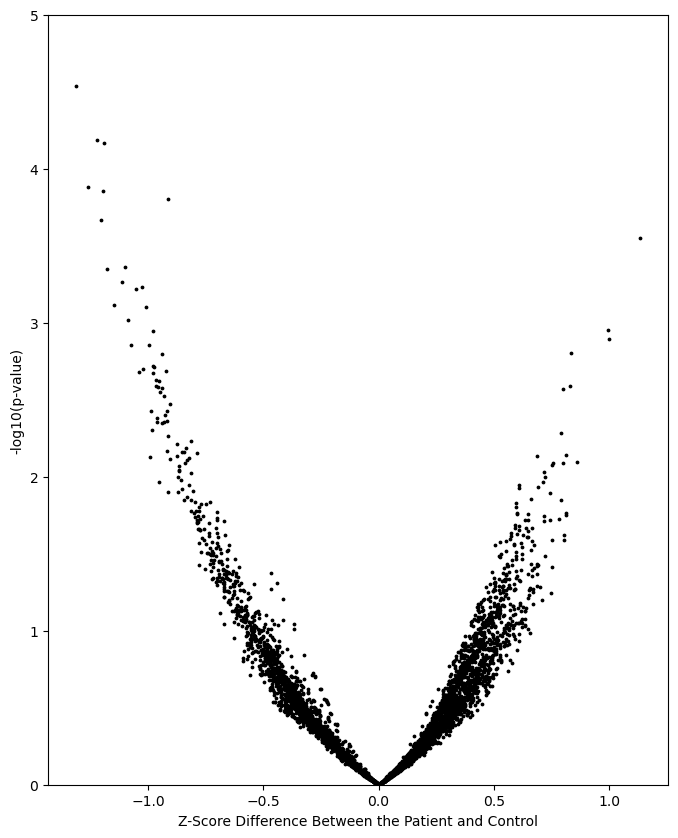

In [52]:
from statsmodels.stats.multitest import multipletests


# create a df of the df dataframe of the columns that are participant row = "patient"
patient_df = df_transposed[df_transposed['Participant'] == 'Patient']
patient_df = patient_df.drop('Participant', axis=1)
patient_df = patient_df.reset_index(drop=True)

# create a df of the df dataframe of the rows that are participant row = "control"
control_df = df_transposed[df_transposed['Participant'] == 'Control']
control_df = control_df.drop('Participant', axis=1)

# # # Replace zeros with NaN
# # patient_df.replace(0, np.nan, inplace=True)
# # control_df.replace(0, np.nan, inplace=True)

# # find the minimum non-zero value
# patient_df_min_non_zero = patient_df[patient_df > 0].min().min()
# control_df_min_non_zero = control_df[control_df > 0].min().min()

# # calculate one third of the minimum non-zero value
# patient_df_value = patient_df_min_non_zero / 3
# control_df_value = control_df_min_non_zero / 3

# # Replace NaNs with the replacement value
# patient_df.fillna(patient_df_value, inplace=True)
# control_df.fillna(control_df_value, inplace=True)

# compute p-value w a two-tailed, equal variance Student's t-test
# THERES AN ISSUE HERE!!!!!
patient_df = patient_df.apply(pd.to_numeric, errors='coerce')
control_df = control_df.apply(pd.to_numeric, errors='coerce')
t_stat, p_values = ttest_ind(patient_df, control_df, equal_var=True, axis=0)

# Calculate log2 fold change (x-axis)
log2_fold_change = (control_df.mean(axis=0)-patient_df.mean(axis=0))

# perform Benjamini-Hochberg correction
# corrected_p_values = multipletests(p_values, method='fdr_bh', alpha=0.05)[1]

# Calculate -log10 of p_value (y-axis)
minus_log10_p_value= -np.log10(p_values)

# # Create figure
plt.figure(figsize=(8, 10))
plt.scatter(log2_fold_change, minus_log10_p_value, color='black', s=3)
plt.xlabel('Z-Score Difference Between the Patient and Control')
plt.ylabel('-log10(p-value)')

# plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.show()


In [38]:
log2_fold_change

Gene
A1BG           NaN
A1CF           NaN
A2M            NaN
A2ML1          NaN
A4GALT         NaN
            ...   
ZPBP2          NaN
ZPLD1          NaN
ZWILCH   -3.151172
ZWINT          NaN
ZYX            NaN
Length: 4735, dtype: float64

In [37]:
sum(minus_log10_p_value>1)

minus_log10_p_value[minus_log10_p_value>1]
log2_fold_change[minus_log10_p_value>1]


Gene
A2M      NaN
A2ML1    NaN
A4GNT    NaN
ABL2     NaN
ACAP2    NaN
          ..
XXYLT1   NaN
YEATS4   NaN
YES1     NaN
ZP4      NaN
ZPLD1    NaN
Length: 594, dtype: float64

In [25]:
patient_df

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
0,-0.208129,-0.419017,-0.369464,-0.681827,0.592530,-0.272978,1.879046,-0.098970,-0.029837,0.646728,...,-1.430593,0.427947,-0.099927,-0.537459,-1.211915,0.368769,-0.076636,-1.356742,-1.241407,-0.567953
1,-0.598398,5.793107,1.399792,0.323497,0.229079,0.384998,-0.825140,-0.430588,-0.649539,0.535298,...,-1.232010,-0.283659,-0.046636,-0.175699,-1.232840,0.884795,0.073319,-0.748043,-0.509283,-0.812421
2,0.899881,-0.085295,-0.371183,1.505926,0.065202,-0.330493,-1.081448,-0.993522,-1.094909,-0.448857,...,1.930746,-0.090478,4.187202,-0.315165,2.417010,-0.054656,-0.120418,2.605768,1.050719,-1.169851
3,0.114559,0.033296,-1.117822,-0.420870,4.052755,-0.207293,-0.684440,-0.709207,-1.062318,0.465183,...,-0.480772,0.293240,-0.161139,-0.161491,-0.670412,1.739867,-0.205470,-0.426434,-0.985067,-1.217936
4,-0.061617,-0.154599,0.368761,-0.587867,1.023772,-0.199223,-0.491550,-0.448963,-0.496959,0.479745,...,0.529766,1.239279,2.837399,-0.424211,-0.828762,1.107536,-0.147179,-0.719847,-1.571345,-0.528291
5,0.287414,-0.432669,-0.826427,-0.532369,0.447598,-0.395434,2.751083,0.046192,0.177629,-0.005303,...,-1.510129,1.901329,-0.291886,-0.330991,-0.825648,-0.013630,-0.573801,-0.506147,-0.655907,0.373342
6,-0.266023,-0.775257,0.092247,-0.897585,-0.549563,-0.410060,-0.590066,-0.519277,0.137447,-0.522038,...,-0.567213,-0.580700,-0.250029,0.815275,-0.364532,-0.463433,-0.057830,-1.175183,-0.715094,0.113600
7,-0.818057,-0.668044,-1.048939,-0.857524,-0.883984,-0.655448,1.326943,1.464248,1.874463,1.768249,...,-1.103605,-0.023181,-0.398468,-0.255006,-0.776821,-0.555780,-0.613502,-0.940080,0.342927,1.371669
8,-0.406598,-0.351571,-1.600334,0.432672,0.049496,-0.323739,0.410688,-0.198533,-0.396266,-0.495586,...,0.027558,-0.871791,-0.110104,-0.330207,1.600546,-0.710100,-0.493255,2.051009,0.612210,-0.817448
9,0.967735,-0.333792,-1.483959,-0.119935,1.193068,-0.344252,-0.730647,0.063211,-0.100029,-0.016741,...,-0.590776,-0.676344,-0.195180,-0.382491,-0.016696,-0.517594,-0.288046,0.050747,2.205883,-0.685597


In [26]:
print(len(log2_fold_change))
print(len(minus_log10_p_value))

4735
4735


In [12]:
#range of minus_log10_p_value
(min(minus_log10_p_value))
(max(minus_log10_p_value))

-0.0

In [13]:
patient_df

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
0,-0.208129,-0.419017,-0.369464,-0.681827,0.592530,-0.272978,1.879046,-0.098970,-0.029837,0.646728,...,-1.430593,0.427947,-0.099927,-0.537459,-1.211915,0.368769,-0.076636,-1.356742,-1.241407,-0.567953
1,-0.598398,5.793107,1.399792,0.323497,0.229079,0.384998,-0.825140,-0.430588,-0.649539,0.535298,...,-1.232010,-0.283659,-0.046636,-0.175699,-1.232840,0.884795,0.073319,-0.748043,-0.509283,-0.812421
2,0.899881,-0.085295,-0.371183,1.505926,0.065202,-0.330493,-1.081448,-0.993522,-1.094909,-0.448857,...,1.930746,-0.090478,4.187202,-0.315165,2.417010,-0.054656,-0.120418,2.605768,1.050719,-1.169851
3,0.114559,0.033296,-1.117822,-0.420870,4.052755,-0.207293,-0.684440,-0.709207,-1.062318,0.465183,...,-0.480772,0.293240,-0.161139,-0.161491,-0.670412,1.739867,-0.205470,-0.426434,-0.985067,-1.217936
4,-0.061617,-0.154599,0.368761,-0.587867,1.023772,-0.199223,-0.491550,-0.448963,-0.496959,0.479745,...,0.529766,1.239279,2.837399,-0.424211,-0.828762,1.107536,-0.147179,-0.719847,-1.571345,-0.528291
5,0.287414,-0.432669,-0.826427,-0.532369,0.447598,-0.395434,2.751083,0.046192,0.177629,-0.005303,...,-1.510129,1.901329,-0.291886,-0.330991,-0.825648,-0.013630,-0.573801,-0.506147,-0.655907,0.373342
6,-0.266023,-0.775257,0.092247,-0.897585,-0.549563,-0.410060,-0.590066,-0.519277,0.137447,-0.522038,...,-0.567213,-0.580700,-0.250029,0.815275,-0.364532,-0.463433,-0.057830,-1.175183,-0.715094,0.113600
7,-0.818057,-0.668044,-1.048939,-0.857524,-0.883984,-0.655448,1.326943,1.464248,1.874463,1.768249,...,-1.103605,-0.023181,-0.398468,-0.255006,-0.776821,-0.555780,-0.613502,-0.940080,0.342927,1.371669
8,-0.406598,-0.351571,-1.600334,0.432672,0.049496,-0.323739,0.410688,-0.198533,-0.396266,-0.495586,...,0.027558,-0.871791,-0.110104,-0.330207,1.600546,-0.710100,-0.493255,2.051009,0.612210,-0.817448
9,0.967735,-0.333792,-1.483959,-0.119935,1.193068,-0.344252,-0.730647,0.063211,-0.100029,-0.016741,...,-0.590776,-0.676344,-0.195180,-0.382491,-0.016696,-0.517594,-0.288046,0.050747,2.205883,-0.685597


In [14]:
df_copy.columns

NameError: name 'df_copy' is not defined

# Correlation analysis

In [ ]:
# amongst all Participants = Patient, find the top 20 with the highest mean value
df_patient = df.loc[:, df.loc['Participant'] == 'Patient']
df_patient = df_patient.drop('Participant')
df_patient = df_patient.apply(pd.to_numeric)
df_patient = df_patient.mean(axis=1)
df_patient = df_patient.sort_values(ascending=False)
df_patient = df_patient.head(20)

In [ ]:
df_patient

AIF1L       0.713905
TNFRSF1A    0.660167
EFNA4       0.653608
PPIC        0.649365
ROR1        0.642501
CRABP2      0.638695
IL18BP      0.633991
IL15RA      0.611514
GDF15       0.598092
TPPP2       0.596133
PXDN        0.585887
NBL1        0.583916
HSPB6       0.577347
UNC5B       0.576397
SELM        0.563590
XXYLT1      0.563154
EFNA5       0.557503
TIMP1       0.552045
FABP4       0.547796
DCP1A       0.544315
dtype: float64

In [ ]:
# get list of unique genes
genes = df.index[:-1].unique().sort_values(ascending = True)
genes

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAGAB', 'AARS',
       'AASDHPPT', 'ABCC6',
       ...
       'ZPBP2', 'ZPLD1', 'ZWILCH', 'ZWINT', 'ZYX', 'apcA apcB', 'magainins',
       'mdh', 'nodH', 'non-human'],
      dtype='object', length=4735)

In [ ]:
df_nolabels_t = df_nolabels.T
corr = df_nolabels_t.corr()

In [ ]:
corr

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
A1BG,1.000000,-0.083510,-0.022669,0.203771,0.122994,-0.007841,-0.269073,-0.241906,-0.348681,-0.218932,...,0.148405,0.003962,0.301280,0.112852,0.319800,0.036129,0.280746,0.307256,0.186326,-0.135460
A1CF,-0.083510,1.000000,0.407747,0.221993,0.218914,-0.055605,0.061951,0.354974,0.166737,0.154306,...,-0.094243,0.067286,-0.013942,-0.195319,-0.292473,0.388332,-0.072033,-0.239737,-0.182738,0.058857
A2M,-0.022669,0.407747,1.000000,0.128871,0.294520,0.082286,-0.011890,0.232433,0.068839,0.305712,...,-0.258613,0.227116,0.040630,0.093110,-0.455670,0.406987,0.011643,-0.424498,-0.151718,0.143300
A2ML1,0.203771,0.221993,0.128871,1.000000,0.159106,0.061802,-0.370057,-0.053422,-0.289666,0.179053,...,0.029218,0.099397,0.156312,-0.118534,0.093282,0.156958,-0.129420,0.069663,0.097996,-0.184929
A4GALT,0.122994,0.218914,0.294520,0.159106,1.000000,-0.056760,-0.021949,0.018130,-0.127103,0.424760,...,-0.315242,0.333263,0.188933,-0.370637,-0.429502,0.583895,-0.169137,-0.318949,0.082248,-0.302403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPBP2,0.036129,0.388332,0.406987,0.156958,0.583895,-0.176326,0.032386,0.029829,-0.093637,0.488569,...,-0.237869,0.396208,0.167499,-0.242115,-0.556948,1.000000,0.013106,-0.485386,-0.142926,-0.151552
ZPLD1,0.280746,-0.072033,0.011643,-0.129420,-0.169137,-0.097202,-0.002179,-0.203349,-0.237687,-0.258362,...,-0.086630,0.089783,0.009883,0.545689,0.028927,0.013106,1.000000,0.109972,0.273972,-0.095679
ZWILCH,0.307256,-0.239737,-0.424498,0.069663,-0.318949,0.229687,-0.379440,-0.443417,-0.431516,-0.552883,...,0.511649,-0.347603,0.196587,0.036622,0.925982,-0.485386,0.109972,1.000000,0.348618,-0.253117
ZWINT,0.186326,-0.182738,-0.151718,0.097996,0.082248,0.002394,-0.210732,-0.220425,-0.249689,-0.110745,...,0.168723,-0.058735,0.000671,0.259689,0.322026,-0.142926,0.273972,0.348618,1.000000,-0.255502


In [ ]:
# ignoring corr = 1.00, get the top 20 correlations
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
corr = corr.stack().sort_values(ascending=False)
corr.head(20)

LCAT         UBE2D3      0.998040
FTH1 FTL     FTL         0.996625
LCAT         MFAP3L      0.996246
ARL6         GCK         0.996154
             LCAT        0.995821
             MFAP3L      0.995626
MFAP3L       UBE2D3      0.995047
ARL6         NAALADL1    0.994873
CHFR         MFAP3L      0.994834
ARL6         UBE2D3      0.994593
             PPA2        0.994223
             CHFR        0.994191
GCK          NAALADL1    0.994026
CDK5 CDK5R1  TPM2        0.993802
CHFR         LCAT        0.993555
ARL6         HPGD        0.993545
CHFR         NAALADL1    0.993454
HPGD         PPA2        0.993453
MFAP3L       NAALADL1    0.993343
             PARP16      0.993256
dtype: float64

In [ ]:
gene_of_interest = "LCAT"
correlations = corr.loc[:, gene_of_interest]
ranked_correlations = correlations.sort_values(ascending = False)

# export the top 100 correlations to a txt file, keeping column 0 only
ranked_correlations.to_csv(f'top100_correlations_{gene_of_interest}.txt', sep='\t', header=False)

# remove the numbers from the text file
with open(f'top100_correlations_{gene_of_interest}.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.split('\t')[0] for line in lines]
    lines = [line + '\n' for line in lines]
    lines = lines[0:100]

with open(f'top100_correlations_{gene_of_interest}.txt', 'w') as f:
    f.writelines(lines)